# Introduction

In this notebook we'll have a very quick look at an image segmentation problem: locating the lateral ventricles in 2D slices of brain MRI images

<img src="assets/brain_segm.png">

> **Note:** To run this notebook locally you have to have the fastai library installed. See https://docs.fast.ai for instructions if you want to install on your own computer. If you're using Google Colab or Paperspace Gradient, running the notebook will install what's necessary.

> Comment ASL, 12.01.22: The notebook is currently not runnable in Colab. Will update it later to make it runnable.

# Setup

In [1]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory, as that makes some difference for the code below.
# We'll do this in every notebook of the course.
if 'google.colab' in str(get_ipython()):
    print('The notebook is running on Colab. colab=True.')
    colab=True
else:
    print('The notebook is not running on Colab. colab=False.')
    colab=False

The notebook is not running on Colab. colab=False.


In [2]:
if colab:
    !pip install -Uqq fastbook
    import fastbook
    fastbook.setup_book()
    from fastbook import *
    !pip install fastai-amalgam
    !pip install palettable
    !pip install matplotlib_venn
    from fastai.vision.all import *
    NB_DIR = Path.cwd()
    DATA = Path('./gdrive/MyDrive/ColabData')
    DATA.mkdir(exist_ok=True)
else:
    from fastai.vision.all import *
    NB_DIR = Path.cwd()
    DATA = Path('/home/alex/data-tmp') # Change this to a Path on your computer 

In [5]:
from PIL import Image

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger

from fastai.vision.core import PILImage, PILMask

# Load data

Based on the freely availabe brain MRI IXI dataset (https://brain-development.org/ixi-dataset/), we've created a segmentation task by using the (slow) software package FreeSurfer to segment the lateral ventricles.

Our task is to take a T1w MRI image as input, and output a segmentation mask for the lateral ventricles. I.e., image-to-image segmentation.

Image segmentation is a fundamental challenge in medical image processing, and this example is meant to illustrate the now widely used deep learning-based approaches. See e.g. A.S. Lundervold & A. Lundervold, [An overview of deep learning in medical imaging focusing on MRI](https://www.sciencedirect.com/science/article/pii/S0939388918301181), 2019.

In [6]:
DATA = Path('/data-ssd/data/IXI/FS_outputs/2D-images')

In [7]:
DATA.ls()

(#645) [Path('/data-ssd/data/IXI/FS_outputs/2D-images/IXI414-Guys-0957-brain-ax3.png'),Path('/data-ssd/data/IXI/FS_outputs/2D-images/IXI490-Guys-1018-orig-ax3.png'),Path('/data-ssd/data/IXI/FS_outputs/2D-images/IXI528-Guys-1073-brain-ax3.png'),Path('/data-ssd/data/IXI/FS_outputs/2D-images/IXI111-Guys-0734-orig-ax3.png'),Path('/data-ssd/data/IXI/FS_outputs/2D-images/IXI144-Guys-0788-orig-ax3.png'),Path('/data-ssd/data/IXI/FS_outputs/2D-images/IXI417-Guys-0939-brain-ax3.png'),Path('/data-ssd/data/IXI/FS_outputs/2D-images/IXI184-Guys-0794-brain-ax3.png'),Path('/data-ssd/data/IXI/FS_outputs/2D-images/IXI110-Guys-0733-orig-ax3.png'),Path('/data-ssd/data/IXI/FS_outputs/2D-images/IXI121-Guys-0772-orig-ax3.png'),Path('/data-ssd/data/IXI/FS_outputs/2D-images/IXI031-Guys-0797-brain-ax3.png')...]

In [8]:
def get_brains_and_masks(ax):
    brain = sorted([str(b) for b in DATA.glob(f'*{ax}*') if 'brain' in str(b)])
    mask = sorted([str(b) for b in (DATA/'ventricles').glob(f'*{ax}*') if 'mask' in str(b)])
    
    df = pd.DataFrame(zip(brain, mask), columns=['img', 'label'])
    
    return df

In [9]:
df = get_brains_and_masks('ax3')

In [10]:
df.head()

,img,label
0,/data-ssd/data/IXI/FS_outputs/2D-images/IXI002-Guys-0828-brain-ax3.png,/data-ssd/data/IXI/FS_outputs/2D-images/ventricles/IXI002-Guys-0828-mask-4+43-ax3.png
1,/data-ssd/data/IXI/FS_outputs/2D-images/IXI016-Guys-0697-brain-ax3.png,/data-ssd/data/IXI/FS_outputs/2D-images/ventricles/IXI016-Guys-0697-mask-4+43-ax3.png
2,/data-ssd/data/IXI/FS_outputs/2D-images/IXI017-Guys-0698-brain-ax3.png,/data-ssd/data/IXI/FS_outputs/2D-images/ventricles/IXI017-Guys-0698-mask-4+43-ax3.png
3,/data-ssd/data/IXI/FS_outputs/2D-images/IXI019-Guys-0702-brain-ax3.png,/data-ssd/data/IXI/FS_outputs/2D-images/ventricles/IXI019-Guys-0702-mask-4+43-ax3.png
4,/data-ssd/data/IXI/FS_outputs/2D-images/IXI020-Guys-0700-brain-ax3.png,/data-ssd/data/IXI/FS_outputs/2D-images/ventricles/IXI020-Guys-0700-mask-4+43-ax3.png


## Create data loaders

In [21]:
size=224
bs=8

In [12]:
db = DataBlock(blocks=(ImageBlock(PILImageBW), MaskBlock(codes)),
                    splitter=RandomSplitter(),
                    get_x=ColReader('img'),
                    get_y=ColReader('label'),
                    batch_tfms=[*aug_transforms(size=size), 
                               Normalize.from_stats(*imagenet_stats)])

In [13]:
dls = db.dataloaders(df, bs=bs)

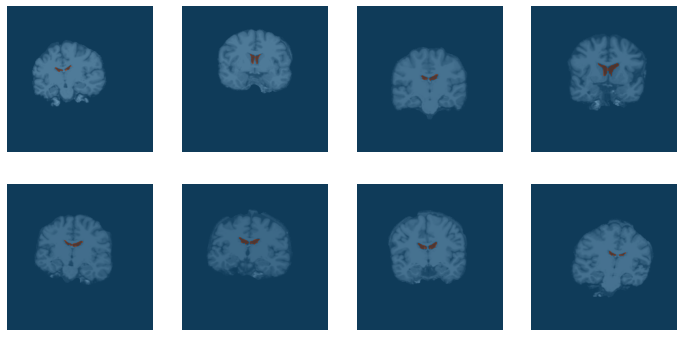

In [14]:
dls.show_batch()

# Construct and train a model

In [15]:
learn = unet_learner(dls, resnet34, loss_func=BCEWithLogitsLossFlat(), 
                     n_out=1, self_attention=True, 
                     act_cls=Mish, opt_func=ranger)

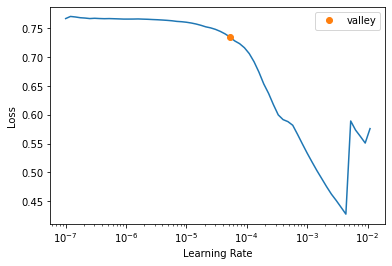

In [16]:
lr = learn.lr_find()

In [17]:
learn.fit_one_cycle(10, lr_max=lr)

epoch,train_loss,valid_loss,time
0,0.733078,0.658373,00:04
1,0.424240,0.040510,00:04
2,0.200272,0.011150,00:04
3,0.102251,0.006786,00:04
4,0.054588,0.005157,00:04
5,0.030528,0.004522,00:04
6,0.018013,0.004395,00:04
7,0.011395,0.003916,00:04
8,0.007792,0.003790,00:04
9,0.005898,0.003721,00:04


# Evaluate results

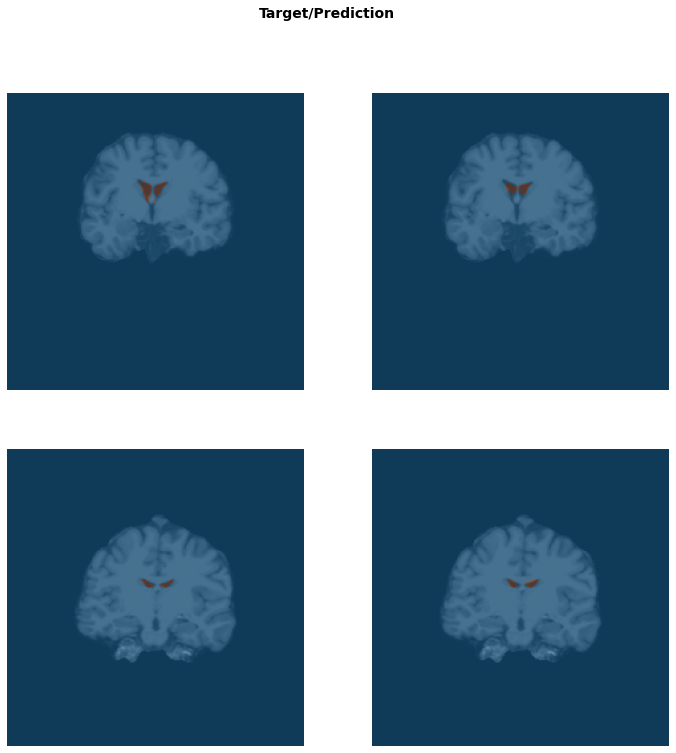

In [18]:
learn.show_results(max_n=2, figsize=(12,12))

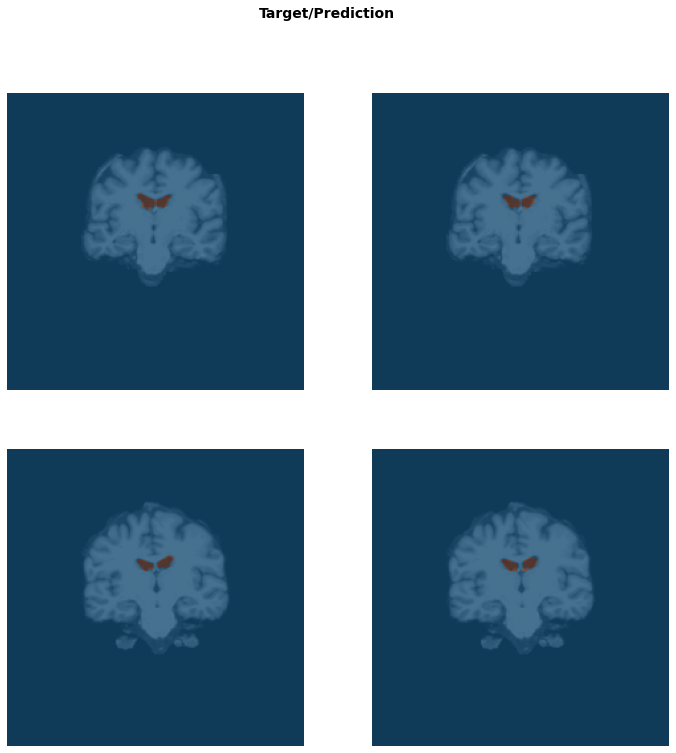

In [19]:
learn.show_results(max_n=2, figsize=(12,12))

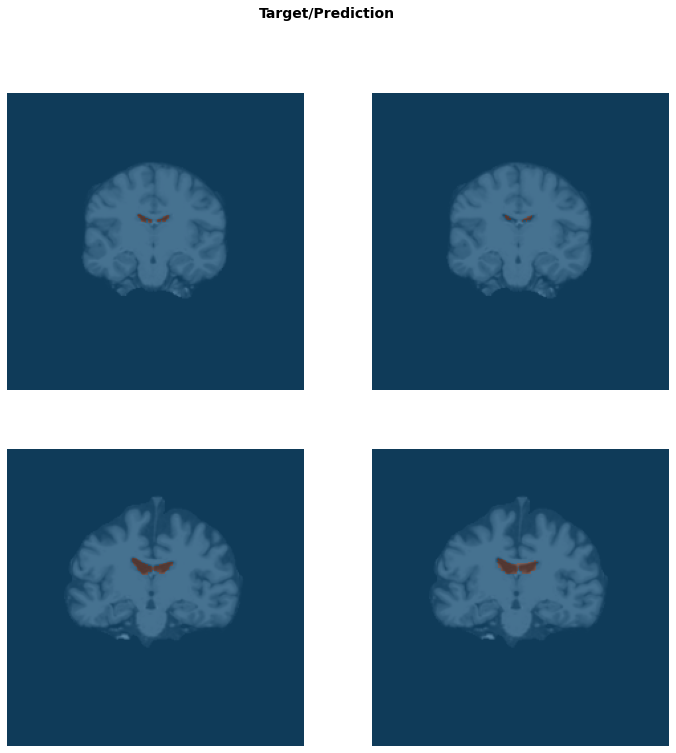

In [20]:
learn.show_results(max_n=2, figsize=(12,12))

# Notes

This was just a very quick example to indicate how one could go about doing image tasks on medical data. 

If you're interested in properly pursuing medical image analysis using deep learning, you should definitely check out the [MONAI](https://monai.io/) library.

<img src="https://monai.io/assets/img/MONAI-logo_color.png">

Our group is also currently developing the _fastMONAI_ library, combining fastai with MONAI. To be publicly released soon. 